In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2, os
import scipy.io as io
import pandas as pd
from scipy import ndimage
from scipy.interpolate import interp1d
from scipy import interpolate
import torch

Text(0.5, 0, 'wavelength [nm]')

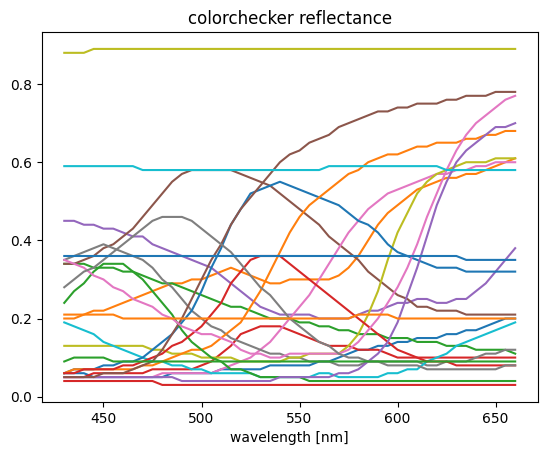

In [2]:
# Replace 'file.csv' with the path to your CSV file
file_path = './dataset/MacbethColorChecker.csv'
# Read the CSV file and store it as a DataFrame
df = pd.read_csv(file_path, header=None, skiprows=2)

# Display the DataFrame
wvls_CC = df.values[1:,0]
wvls_CC = [float(x) for x in wvls_CC] 
ref_CC = df.values[1:,1:-2]

ind_min = 6
ind_max = 61
wvls_CC = wvls_CC[ind_min:ind_max][4:-4]
ref_CC = ref_CC[ind_min:ind_max,:][4:-4]

plt.figure()
plt.plot(wvls_CC, ref_CC)
plt.title('colorchecker reflectance')
plt.xlabel('wavelength [nm]')

In [3]:
# arguments
cam_H, cam_W = 580, 890
wvls = np.arange(430, 670, 10) # 430nm 부터 시작

depth_start = 600
depth_end = 900     
depth_arange = np.arange(depth_start, depth_end + 1, 1)

n_illum = 318
n_patches = 24
n_channel = 3

patch_idx = np.arange(0, 24)
patch_size = 3

# date of datas
date = "0926"

real_data_dir = "./dataset/data/2023%s_real_data/"%date
opt_param_dir = "./calibration/radiometric_cal/opt_params/opt_param_0915_detach_09500.npy"

### PEF, CRF, DG Efficiency

In [4]:
# bring initial value of PEF and CRF
PEF = np.load('./dataset/image_formation/CRF_proj.npy')
map_scale = interp1d([PEF.min(), PEF.max()], [0.,1])
PEF = map_scale(PEF).astype(np.float32)
PEF = PEF[3:27] # from 430nm

CRF = np.load('./dataset/image_formation/CRF.npy')[:,1:].T # from 430nm

dg_intensity = np.load('./dataset/image_formation/dg_efficiency.npy')[1:] # from 430nm

In [5]:
def cubic_interpolation(x_new, x_points, y_points, n):
    tck = interpolate.splrep(x_points, y_points, k=n)   # Estimate the polynomial of nth degree by using x_points and y_points
    y_new = interpolate.splev(x_new, tck)
    return y_new

# wvls from 430 ~ 660 without 630nm
wvls = np.arange(430, 670, 10)
wvls = torch.tensor(wvls)*1e-9
new_wvls = torch.linspace(430*1e-9, 660*1e-9, 47) # 400 ~ 680 까지 10nm 간격으로

In [6]:
# interpolated CRF for 5nm
CRF_R = cubic_interpolation(new_wvls, wvls, CRF[:,0], 4)
CRF_G = cubic_interpolation(new_wvls, wvls, CRF[:,1], 4)
CRF_B = cubic_interpolation(new_wvls, wvls, CRF[:,2], 4)

# interpolated PEF for 5nm
PEF_R = cubic_interpolation(new_wvls, wvls, PEF[:,0], 4)
PEF_G = cubic_interpolation(new_wvls, wvls, PEF[:,1], 4)
PEF_B = cubic_interpolation(new_wvls, wvls, PEF[:,2], 4)

# interpolated CRF for 5nm
dg_efficiency_R = cubic_interpolation(new_wvls, wvls, dg_intensity[:,0], 4)
dg_efficiency_G = cubic_interpolation(new_wvls, wvls, dg_intensity[:,1], 4)
dg_efficiency_B = cubic_interpolation(new_wvls, wvls, dg_intensity[:,2], 4)

In [7]:
CRF_intp = np.stack((CRF_R, CRF_G, CRF_B))
PEF_intp = np.stack((PEF_R, PEF_G, PEF_B))
dg_intensity_intp = np.stack((dg_efficiency_R, dg_efficiency_G, dg_efficiency_B))

#### Optimized paramter update

In [8]:
# bring optimized parameters
opt_param_final = np.load(opt_param_dir)

# update parameter
CRF = CRF_intp.T * opt_param_final[:,3:-2]
PEF = PEF_intp.T * opt_param_final[:,:3]
dg_intensity_intp[2] = dg_intensity_intp[2] * opt_param_final[:,-1]
dg_intensity_intp[0] = dg_intensity_intp[0] * opt_param_final[:,-2]
DG_efficiency = dg_intensity_intp

(<AxesSubplot:title={'center':'5nm interpolated DG Efficiency'}>,
 Text(0.5, 1.0, '5nm interpolated DG Efficiency'))

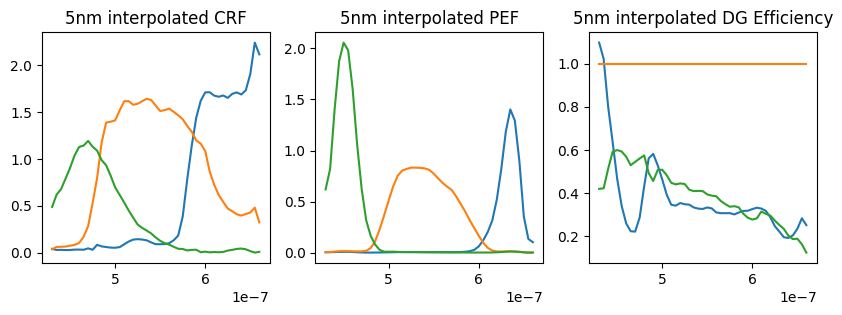

In [9]:
plt.figure(figsize=(10,3))
plt.subplot(131), plt.plot(new_wvls, CRF), plt.title('5nm interpolated CRF')
plt.subplot(132), plt.plot(new_wvls, PEF), plt.title('5nm interpolated PEF')
plt.subplot(133), plt.plot(new_wvls, DG_efficiency.T), plt.title('5nm interpolated DG Efficiency')

In [10]:
# # load original hdr data
# hdr_imgs = np.load('./hdr_step5.npy') / 65535

# # median filter
# hdr_imgs_filtered_R = np.array([ndimage.median_filter(image[:,:,0], size=4) for image in hdr_imgs])
# hdr_imgs_filtered_G = np.array([ndimage.median_filter(image[:,:,1], size=4) for image in hdr_imgs])
# hdr_imgs_filtered_B = np.array([ndimage.median_filter(image[:,:,2], size=4) for image in hdr_imgs])

# hdr_imgs_filtered = np.stack((hdr_imgs_filtered_R, hdr_imgs_filtered_G, hdr_imgs_filtered_B), axis = 3)

# # save
# np.save('hdr_imgs_filtered.npy', hdr_imgs_filtered)

# load
hdr_imgs = np.load('hdr_imgs_filtered.npy') # 318, 580, 890, 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


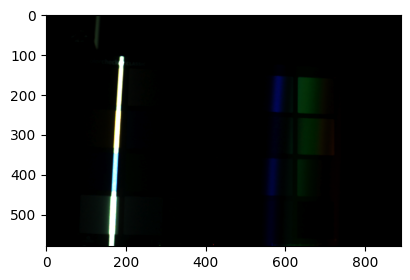

In [11]:
plt.figure(figsize=(5,3))
plt.imshow(hdr_imgs[100])

## Bring depth

In [12]:
depth = np.load(os.path.join(real_data_dir,'./2023%s_color_checker.npy'%date))[:,:,2]*1e+3

(<matplotlib.image.AxesImage at 0x1198703bc48>,
 <matplotlib.colorbar.Colorbar at 0x1198706f9c8>)

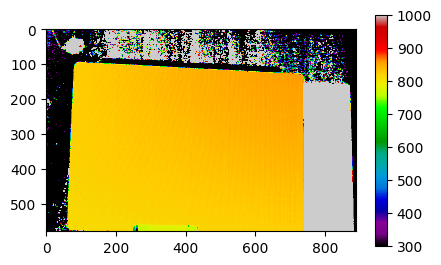

In [13]:
plt.figure(figsize=(5,3))
plt.imshow(depth, vmin=300, vmax = 1000, cmap='nipy_spectral'), plt.colorbar()

In [14]:
depth = np.round(depth).reshape(cam_H* cam_W).astype(np.int16)

## Depth dependent peak illumination index

In [15]:
first_illum_idx = np.load('./first_illum_idx_final_transp.npy')

In [16]:
first_illum_idx = first_illum_idx.reshape(len(new_wvls), len(depth_arange), cam_H*cam_W).transpose(1,0,2)

### zero order

In [17]:
zero_illum_idx = np.zeros(shape=(cam_H * cam_W))
hdr_imgs_reshape = hdr_imgs.reshape(n_illum, cam_H*cam_W, 3)

for i in range(cam_H*cam_W):
    max_idx = np.argmax(hdr_imgs_reshape[:,i].mean(axis = 1))
    zero_illum_idx[i] = max_idx

zero_illum_idx = np.round(zero_illum_idx)

## Get valid first order illumination idx

In [18]:
# f(x, y, z) = (430 - 660) index

In [19]:
real_img_illum_idx = np.zeros(shape=(len(new_wvls), cam_H*cam_W))
for i in range(cam_H*cam_W):
        depth_idx = np.where(depth_arange == depth[500000])[0][0]
        real_img_illum_idx[:,i]= first_illum_idx[depth_idx,:,i]

In [20]:
real_img_illum_idx = real_img_illum_idx.astype(np.int16).reshape(len(new_wvls), cam_H, cam_W)
real_img_illum_idx_final = np.stack((real_img_illum_idx, real_img_illum_idx, real_img_illum_idx), axis = 3)

### Diffraction grating efficiency

In [21]:
real_img_illum_idx_reshape = real_img_illum_idx.reshape(len(new_wvls), cam_H*cam_W)

In [22]:
# DG efficiency for all pixels
DG_efficiency_image = np.zeros(shape=(cam_H * cam_W, len(new_wvls)))

for i in range(cam_H * cam_W):
    if zero_illum_idx[i] > real_img_illum_idx_reshape[0,i]: # 430nm # -1 order
        DG_efficiency_image[i,:] =  DG_efficiency[0]
    elif zero_illum_idx[i] < real_img_illum_idx_reshape[0,i]: # +1 order
        DG_efficiency_image[i,:] =  DG_efficiency[2]
    else: # else
        DG_efficiency_image[i,:] = 0

### Simulation

In [23]:
ref_CC[:,18].shape

(47,)

In [24]:
white_pattern = np.ones(shape = (1, 3))*0.8
white_pattern_hyp = white_pattern @ PEF.T
                    # 47, 1
Simulated_I_RGB = (ref_CC[:,18][:,np.newaxis] * white_pattern_hyp.transpose(1,0) * DG_efficiency[2][:,np.newaxis]) * CRF

In [26]:
x, y, z = np.meshgrid(np.arange(580), np.arange(890), np.arange(3), indexing='ij')

GT_I_RGB = hdr_imgs[real_img_illum_idx_final, x, y, z].transpose(1, 2, 0, 3)    

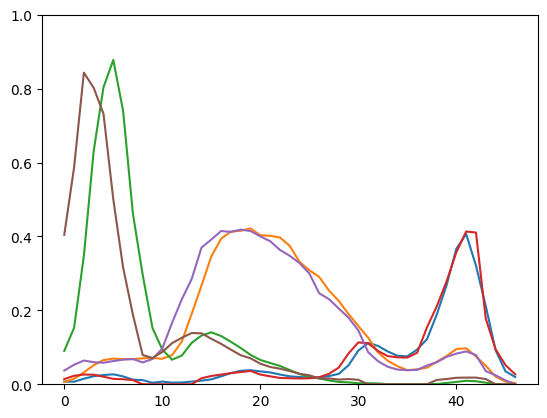

In [28]:
for i in range(len(all_patches_center_pts)):
    plt.figure()
    plt.ylim([0,1])
    plt.xlabel('illumination index')
    plt.ylabel('intensity')
    plt.plot(Simulated_I_RGB)
    plt.plot(GT_I_RGB[all_patches_center_pts[i,1],all_patches_center_pts[i,0]])

## SVD

In [29]:
n_lambda = 47
weight_D = 0.5
device = 'cuda:0'

# D matrix
i_mat = np.eye(n_lambda)
diagonal_indices = np.diag_indices(i_mat.shape[0])
new_diagonal_indices_col = np.copy(diagonal_indices[1])
new_diagonal_indices_col[:-1] = diagonal_indices[1][:-1] + 1
i_mat[(diagonal_indices[0], new_diagonal_indices_col)] = -1
D = i_mat
D[-1] = i_mat[-2]

D = torch.tensor(D, device=device)

# to tensor, device
CRF = torch.tensor(CRF, device=device).type(torch.float32)
PEF = torch.tensor(PEF, device=device).type(torch.float32)
hdr_imgs_t = torch.tensor(hdr_imgs, device=device)
first_illum_idx_final_transp_t = torch.tensor(real_img_illum_idx_final, device=device)
DG_efficiency_image_t = torch.tensor(DG_efficiency_image.reshape(cam_H*cam_W, -1), device= device) # H x W, wvls

# pattern
white_patt = torch.ones(size = (cam_H * cam_W, 3), device=device) * 0.8
white_patt_hyp = white_patt @ PEF.T
white_patt_hyp = white_patt_hyp.squeeze()

CRF_sum = torch.tensor(CRF, device=device).sum(axis = 1)

total_hyp_ref = []

# summation of Image RGB channel
I_C = hdr_imgs_t[first_illum_idx_final_transp_t.long(), x, y, z].permute(1, 2, 0, 3).sum(axis = 3).reshape(-1, n_lambda, 1) # H x W, wvls, 1
A = (CRF_sum.unsqueeze(dim = 0) * white_patt_hyp * DG_efficiency_image_t).unsqueeze(dim =2) # HxW, wvls, 1


c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [30]:
A_diag = torch.diag_embed((A*A).squeeze())

weight_D_DT = (weight_D*D.T@D).unsqueeze(dim = 0)

# (1)
# pinv = torch.linalg.pinv(A_diag + weight_D_DT) # r*c, wvls, wvls
# csj_x = pinv @ (A*I_C.reshape(cam_H*cam_W, n_lambda,1))

# (2)
csj_x = torch.linalg.solve(A_diag + weight_D_DT, A*I_C.reshape(cam_H*cam_W, n_lambda,1))

# (3)
# csj_x = torch.linalg.lstsq(A_diag + weight_D_DT, A*I_C.reshape(cam_H*cam_W, n_lambda,1))
# csj_x = csj_x.solution

total_hyp_ref = csj_x.squeeze()
total_hyp_ref = total_hyp_ref.reshape(cam_H, cam_W, n_lambda)

In [32]:
total_hyp_ref = total_hyp_ref.detach().cpu().numpy()

In [40]:
## center patches
all_patches_center_pts = np.array([[145,175], [250,180], [360,190], [460,190], [570,190], [675,200],
[138,289], [250,290], [350,300], [460,300], [570,300], [670,300],
[135,390], [246,395], [350,400], [460,400], [570,400], [670,400],
[130,500], [240,500], [350,500], [460,510], [570,510], [680,510]])

In [41]:
all_patches_center_pts.shape

(24, 2)

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


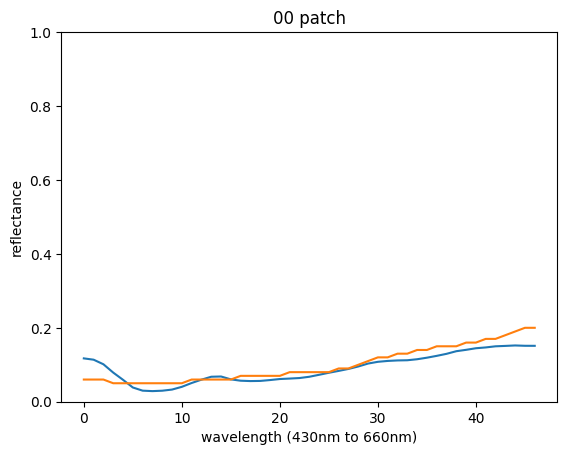

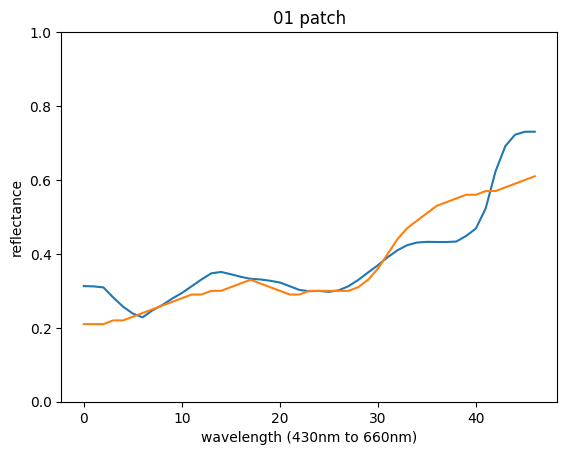

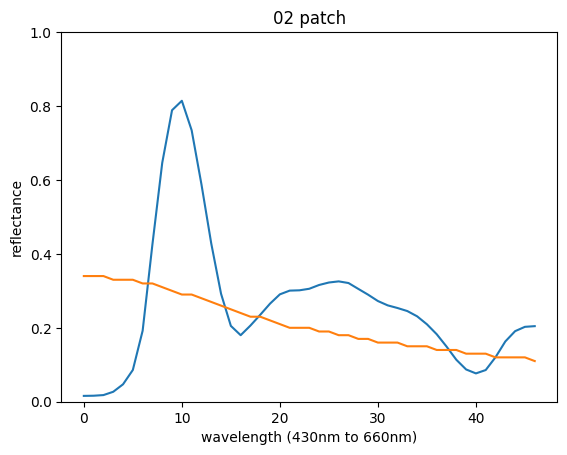

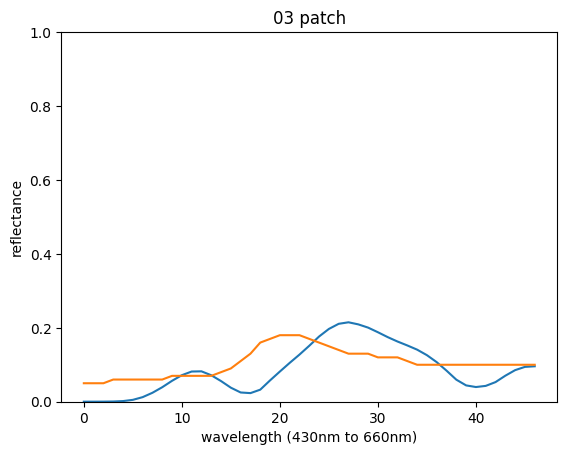

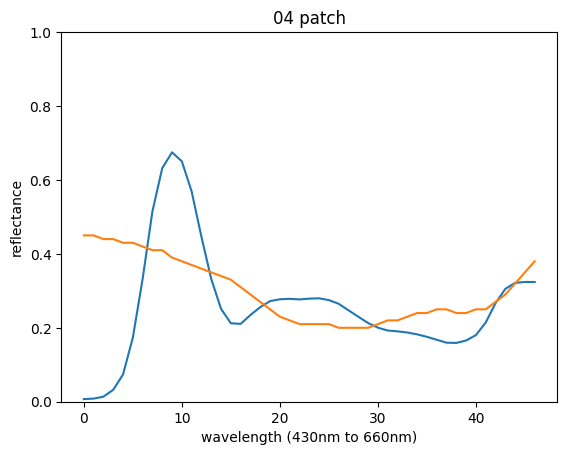

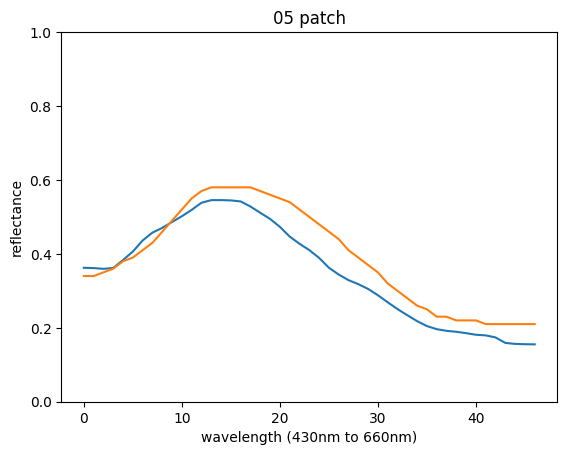

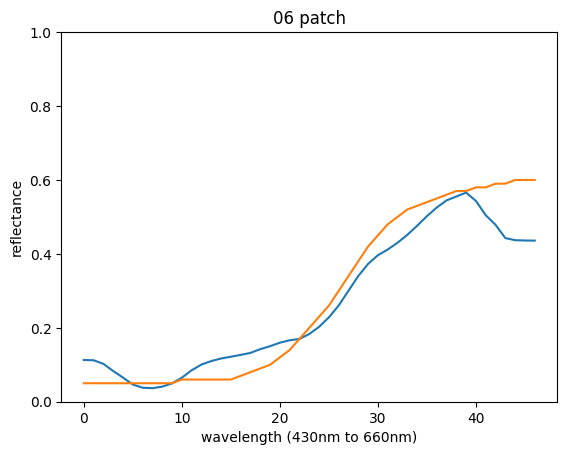

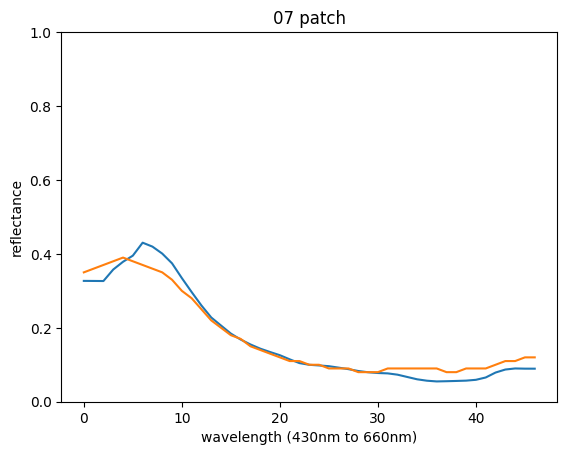

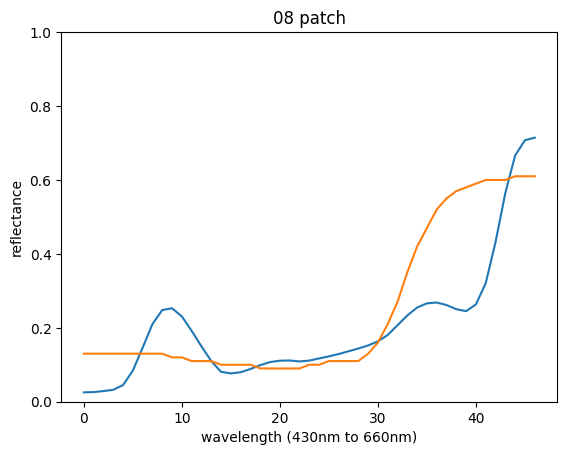

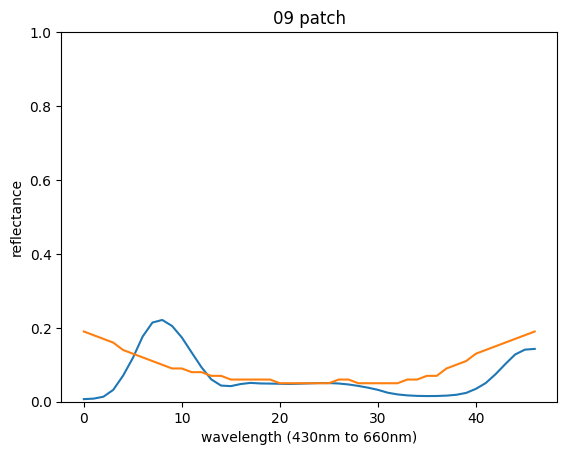

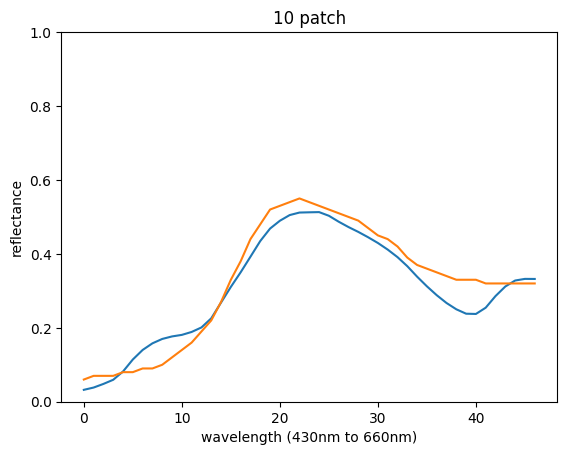

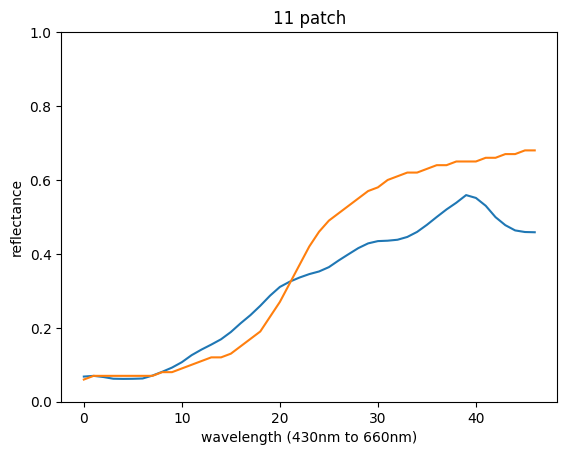

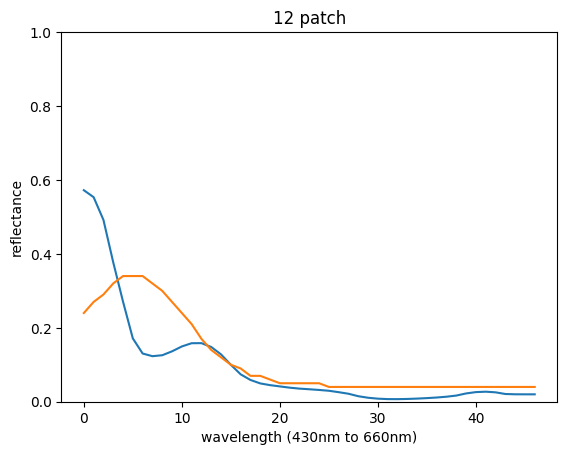

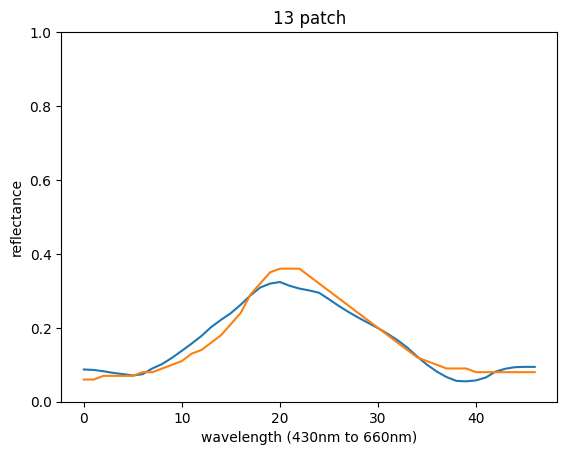

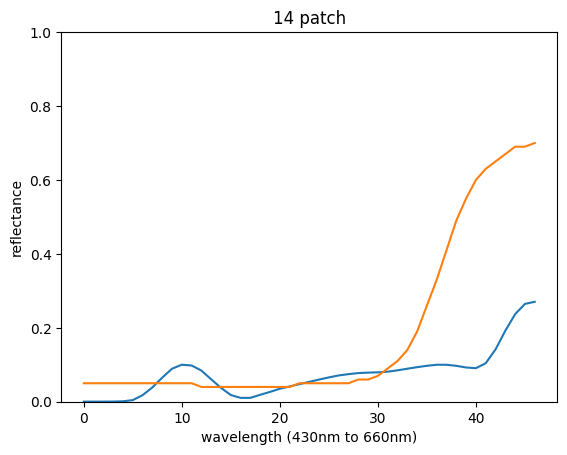

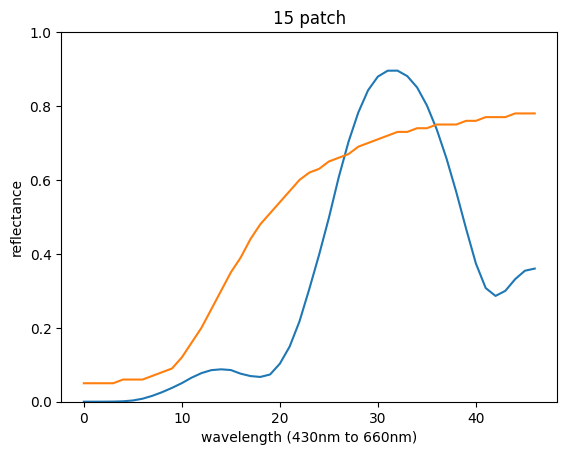

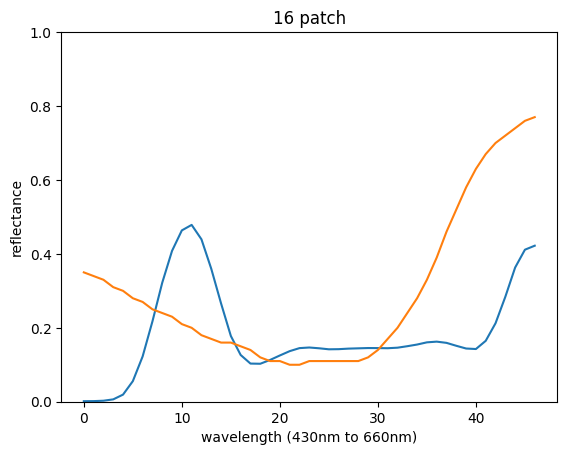

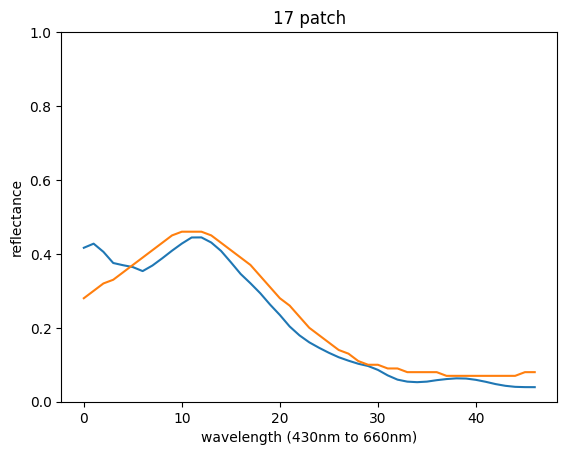

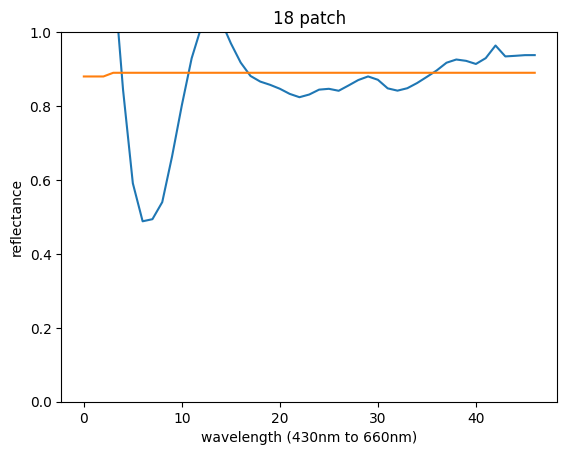

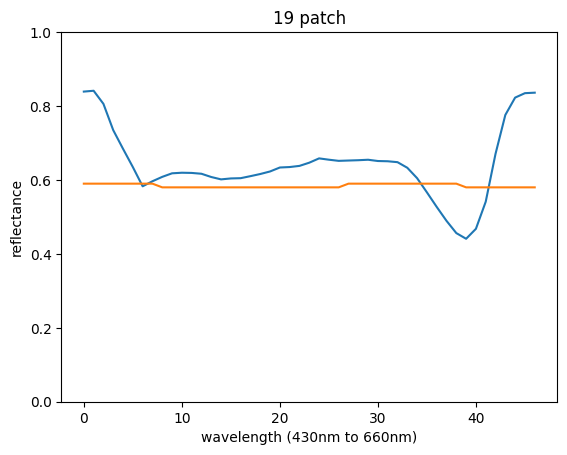

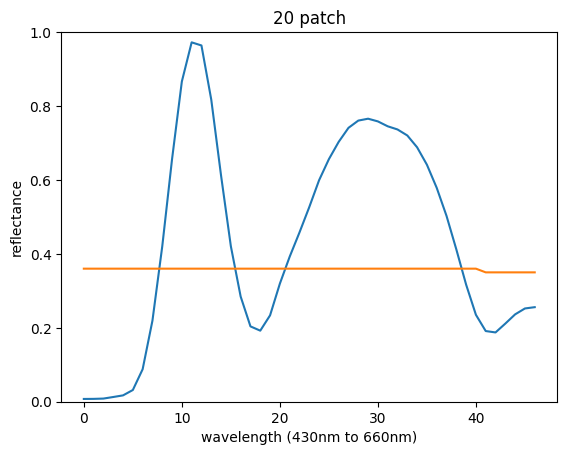

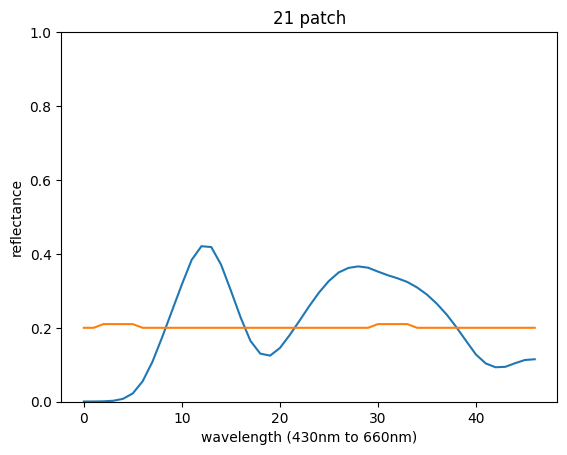

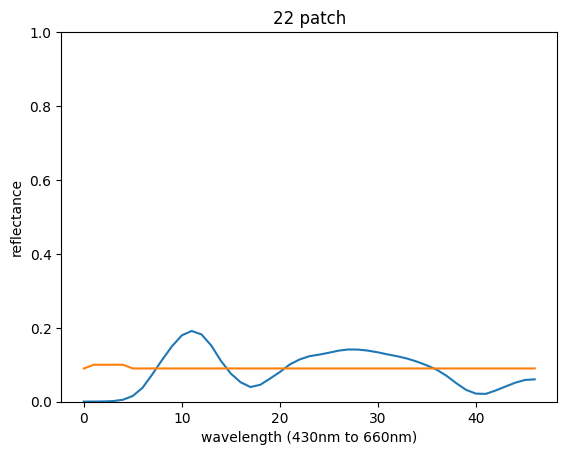

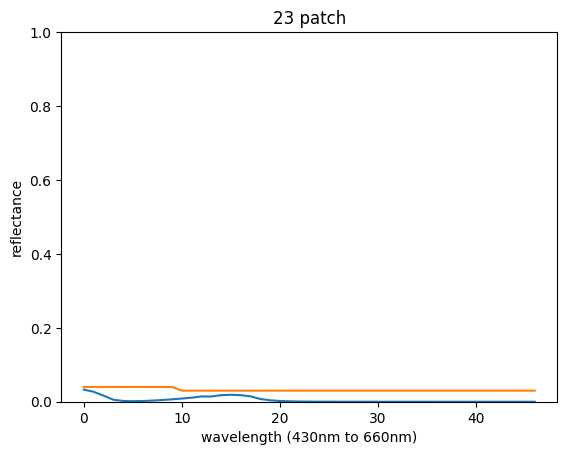

In [48]:
for i in range(len(all_patches_center_pts)):
    plt.figure()
    plt.ylim([0,1])
    plt.xlabel('wavelength (430nm to 660nm)')
    plt.ylabel('reflectance')
    plt.plot(total_hyp_ref[all_patches_center_pts[i,1],all_patches_center_pts[i,0]]), plt.plot(ref_CC[:,i]), plt.title('%02d patch'%i)
    plt.savefig('./%02d_patch.png'%i)

In [35]:
CRF = np.array(CRF.detach().cpu().numpy())

In [36]:
rgb_img = total_hyp_ref@CRF

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


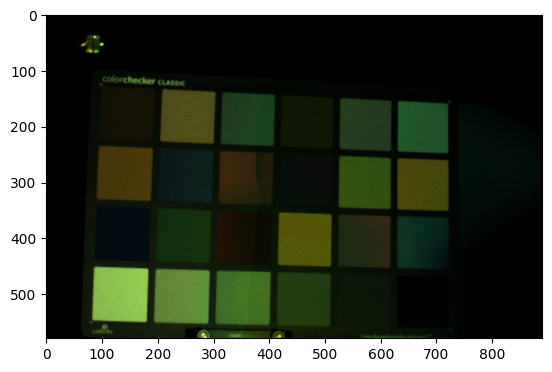

In [46]:
plt.imshow(rgb_img/50)